![](https://www.pata.org/wp-content/uploads/2014/09/TripAdvisor_Logo-300x119.png)
# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor
**По ходу задачи:**
* Прокачаем работу с pandas
* Научимся работать с Kaggle Notebooks
* Поймем как делать предобработку различных данных
* Научимся работать с пропущенными данными (Nan)
* Познакомимся с различными видами кодирования признаков
* Немного попробуем [Feature Engineering](https://ru.wikipedia.org/wiki/Конструирование_признаков) (генерировать новые признаки)
* И совсем немного затронем ML
* И многое другое...   



### И самое важное, все это вы сможете сделать самостоятельно!

*Этот Ноутбук являетсся Примером/Шаблоном к этому соревнованию (Baseline) и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.

> что такое baseline решение, зачем оно нужно и почему предоставлять baseline к соревнованию стало важным стандартом на kaggle и других площадках.   
**baseline** создается больше как шаблон, где можно посмотреть как происходит обращение с входящими данными и что нужно получить на выходе. При этом МЛ начинка может быть достаточно простой, просто для примера. Это помогает быстрее приступить к самому МЛ, а не тратить ценное время на чисто инженерные задачи. 
Также baseline являеться хорошей опорной точкой по метрике. Если твое решение хуже baseline - ты явно делаешь что-то не то и стоит попробовать другой путь) 

В контексте нашего соревнования baseline идет с небольшими примерами того, что можно делать с данными, и с инструкцией, что делать дальше, чтобы улучшить результат.  Вообще готовым решением это сложно назвать, так как используются всего 2 самых простых признака (а остальные исключаются).

# import

In [1010]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import re
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import date

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer # Для кодирования Cuisine Style в dummy-переменные


# Инструмены для ML и расчета MAE
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [1011]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [1012]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# Пользовательские функции

In [1013]:
def city_pop_cut(Series, quant=3):
    
    '''
    Функция для создания порядкового категориального признака
    основанного на количестве населения. 
    ###
    На вход подается колонка с численностью населения в городе (series)
    
    На выходе - объект pop_cat_q типа Series
    ###
    quant - количество групп на которые будут делиться города, по умолчанию - 3
    можно установить значения 3, 5, 6.
    ###
    lables - обозначения групп в датасете, по умолчанию [1, 2, 3], 
    где 1<2<3. 
    
    
    '''
    
    if quant == 3:
        pop_cat_3 = pd.qcut(Series, q=[0, 1/3, 2/3, 1],  labels=[1, 2, 3])
        return pop_cat_3
    
    elif quant == 5:
        pop_cat_5 = pd.qcut(Series, q=[0, .2, .4, .6, .8, 1],  labels=[1, 2, 3, 4, 5])
        return pop_cat_5
    
    elif quant == 6:
        pop_cat_6 = pd.qcut(Series, q=[0, 1/6, 1/3, .5, 2/3, 5/6, 1],  labels=[1, 2, 3, 4, 5, 6])
        return pop_cat_6
    
def reviews_to_date(data):
    '''''' # FIXME
    pattern = re.compile("\d+\/\d+\/\d+")
    data['review_date'] = data['Reviews'].apply(pattern.findall)

    data['review_date'] = data['review_date'].apply(lambda x: [x[-2], x[-1]] if len(x)>=3 else x)

    # случаи с одной датой и с двумя датами
    data['review_date_1'] = data['review_date'].apply(lambda x: x[0] if len(x)>=1 else None)
    data['review_date_2'] = data['review_date'].apply(lambda x: x[1] if len(x)==2 else None)

    # преобразуем к типу datetime
    data['review_date_1'] = pd.to_datetime(data['review_date_1'])
    data['review_date_2'] = pd.to_datetime(data['review_date_2'])
    
def rank_for_city(DataFrame):
    
    ''' 
    Перевод признака Ranking в порядковую категориальную переменную,
    
    группировкой ее на 5 интервалов, с учетом количества населенияв городе
    
    («Топовый», «высокий», «средний», «ниже среднего», «низкий»), где:
    - 5 - Топовый
    - ...
    - 1 - Низкий
    - 0 - Нет ранга
    - При этом 5<4<3<2<1 
    
    На вход подается датафрем, на выходе датафрем + 3 колонки:
    - 'Big_City_Rank'
    - 'Mid_City_Rank'
    - 'Lit_City_Rank'

    '''
    # Создаем серии с рангом ресторана для каждой группы городов
    rating_in_big_city = DataFrame[DataFrame['Pop_cat'] == 3]['Ranking']
    rating_in_mid_city = DataFrame[DataFrame['Pop_cat'] == 2]['Ranking']
    rating_in_lit_city = DataFrame[DataFrame['Pop_cat'] == 1]['Ranking']
    
    
    DataFrame['Big_City_Rank'] = pd.qcut(rating_in_big_city, q=[0, .2, .4, .6, .8, 1], labels=[1, 2, 3, 4, 5])
    DataFrame['Big_City_Rank'] = DataFrame['Big_City_Rank'].astype('float') # Изменим тип колонки, чтобы заполнить Nan - 0
    DataFrame['Big_City_Rank'].fillna(0, inplace=True)
    
    DataFrame['Mid_City_Rank'] = pd.qcut(rating_in_mid_city, q=[0, .2, .4, .6, .8, 1], labels=[1, 2, 3, 4, 5])
    DataFrame['Mid_City_Rank'] = DataFrame['Mid_City_Rank'].astype('float') 
    DataFrame['Mid_City_Rank'].fillna(0, inplace=True)
    
    DataFrame['Lit_City_Rank'] = pd.qcut(rating_in_lit_city, q=[0, .2, .4, .6, .8, 1], labels=[1, 2, 3, 4, 5])
    DataFrame['Lit_City_Rank'] = DataFrame['Lit_City_Rank'].astype('float') 
    DataFrame['Lit_City_Rank'].fillna(0, inplace=True)
    
    return DataFrame    
    
def cuisine_count(data):
    '''
    Функция для подстчета количества кухонь в датасете
    
    '''
    dft = data['Cuisine Style']
    dft = dft.apply(clean_name)
    dfte = dft.explode() # Для подсчета всех кухонь в датасете
    print ('Всего в датасете представлено {} кухонь'.format(len(dfte.value_counts())-1))
    
    
    
def clean_name(str_val):
    
    """
    Преобразует строку с названиями кухонь в список [list] названий кухонь.
    На входе:
        - строковая переменная, содержащая названия кухонь.
    На выходе:
        - список [list] названий кухонь.
    """
    if pd.isna(str_val): return ["Unknown"]
    str_val = str_val.strip('[]') # Отбрасываем скобки.
    str_val = str_val.replace("\'",'') # Убираем кавычки '.
    str_val = str_val.split(", ") # Разбиваем строку по названиям кухонь.
    return str_val


def draw_bp(data, column):
    ''' 
    Функция для отрисовки боклсплота для конкретного признака
    по целевой переменной Rating.
    
    '''
    
    fig, ax = plt.subplots(figsize=(15, 5))
    sns.boxplot(x=column, y='Rating', data=data, ax=ax)
    ax.set_title('Боксплот для ' + column)
    plt.show()
    


# DATA

In [1014]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv('main_task.csv')
df_test = pd.read_csv('kaggle_task.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [1015]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [1016]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [1017]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      10000 non-null  object 
 1   City               10000 non-null  object 
 2   Cuisine Style      7693 non-null   object 
 3   Ranking            10000 non-null  float64
 4   Price Range        6525 non-null   object 
 5   Number of Reviews  9343 non-null   float64
 6   Reviews            9998 non-null   object 
 7   URL_TA             10000 non-null  object 
 8   ID_TA              10000 non-null  object 
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [1018]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [1019]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [1020]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Restaurant_id  10000 non-null  object 
 1   Rating         10000 non-null  float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [1021]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [1022]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [1023]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
32308,id_2170,Munich,NaN,2186.0,NaN,2.0,"[[], []]",/Restaurant_Review-g187309-d5819039-Reviews-Mi...,d5819039,1,4.0
30157,id_4980,London,['Italian'],4989.0,$$ - $$$,11.0,"[['Great flavours', 'Amazing vibe, great food,...",/Restaurant_Review-g186338-d12527329-Reviews-V...,d12527329,1,5.0
39378,id_11594,London,"['Cafe', 'Kosher', 'Vegetarian Friendly']",11604.0,$$ - $$$,33.0,"[['Fair', 'Good Food'], ['01/09/2018', '09/10/...",/Restaurant_Review-g186338-d4056304-Reviews-Ka...,d4056304,1,3.5
7122,id_7122,Rome,"['Italian', 'Mediterranean', 'Vegetarian Frien...",874.0,$$ - $$$,213.0,"[['Great Experience', 'Real Cool place'], ['08...",/Restaurant_Review-g187791-d12310449-Reviews-L...,d12310449,0,0.0
31963,id_11815,London,"['Spanish', 'Mediterranean']",11825.0,$$ - $$$,12.0,"[['Delicious food and nice service:)', 'Great ...",/Restaurant_Review-g186338-d4593775-Reviews-2N...,d4593775,1,4.0


### Прупуски в DATA

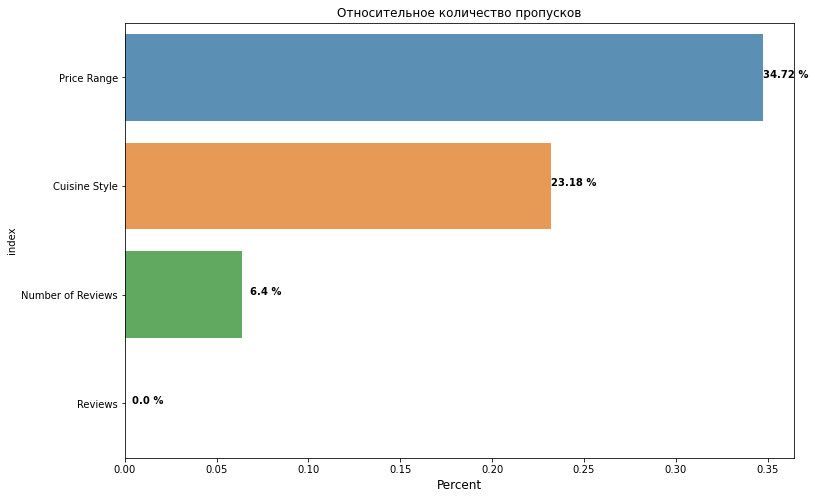

In [1024]:
# Считаем процент пропусков
per_none = pd.DataFrame(1-data.count()/data.shape[0]).reset_index().rename({0: 'percent'}, axis=1)
per_none = per_none.sort_values('percent', ascending=False).query('percent>0')

# Визуализация пропусков
fig, ax = plt.subplots(figsize = (12, 8))
bar_plot = sns.barplot(x='percent', y='index', data=per_none, alpha=0.8, ci=None)
for ytick in bar_plot.get_yticks():
    if per_none.iloc[ytick][1]>0:
        bar_plot.text(per_none.iloc[ytick][1]+0.0125, ytick, str(round(per_none.iloc[ytick][1]*100,2))+' %', 
                    horizontalalignment='center',size=10, color='black', weight='semibold')
plt.title('Относительное количество пропусков')
plt.gca().set_xlabel('Percent', fontsize=12)
plt.show()

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

# Рассмотрим признаки датасета по отдельности

### Restaurant_id - порядковый номер ресторана

In [1025]:
data.loc[:, ['Restaurant_id']].info()
display(data.Restaurant_id.value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Restaurant_id  50000 non-null  object
dtypes: object(1)
memory usage: 390.8+ KB


id_436      19
id_871      19
id_633      19
id_227      19
id_430      18
            ..
id_7505      1
id_8936      1
id_12558     1
id_14975     1
id_13473     1
Name: Restaurant_id, Length: 13094, dtype: int64

нет пропусков но есть повторяющиеся значения - можно сделать вывод что это сеть ресторанов. Добавим новый признак в нашу модель - представим что 0 будет соответствовать уникальному ресторану (id = 1) а 1 будет отвечать сети ресторанов (id > 1)

In [1026]:
restaurant_chain = data['Restaurant_id'].value_counts()[data['Restaurant_id'].value_counts()>1].index.tolist()
data['Restaurant_chain'] = data[data['Restaurant_id'].isin(restaurant_chain)].Restaurant_id.apply(lambda x: 1) # заполняем единицей
data['Restaurant_chain'] = data['Restaurant_chain'].fillna(0) # заролняем остаток 0
data['Restaurant_chain'].describe()

count    50000.000000
mean         0.923860
std          0.265225
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: Restaurant_chain, dtype: float64

### City

In [1027]:
data.City.value_counts()

London        7193
Paris         6108
Madrid        3813
Barcelona     3395
Berlin        2705
Milan         2694
Rome          2589
Prague        1816
Lisbon        1647
Vienna        1443
Amsterdam     1372
Brussels      1314
Hamburg       1186
Munich        1145
Lyon          1126
Stockholm     1033
Budapest      1021
Warsaw         925
Dublin         836
Copenhagen     819
Athens         776
Edinburgh      745
Zurich         685
Oporto         642
Geneva         590
Krakow         554
Oslo           488
Helsinki       475
Bratislava     380
Luxembourg     263
Ljubljana      222
Name: City, dtype: int64

In [1028]:
data['City'].nunique()

31

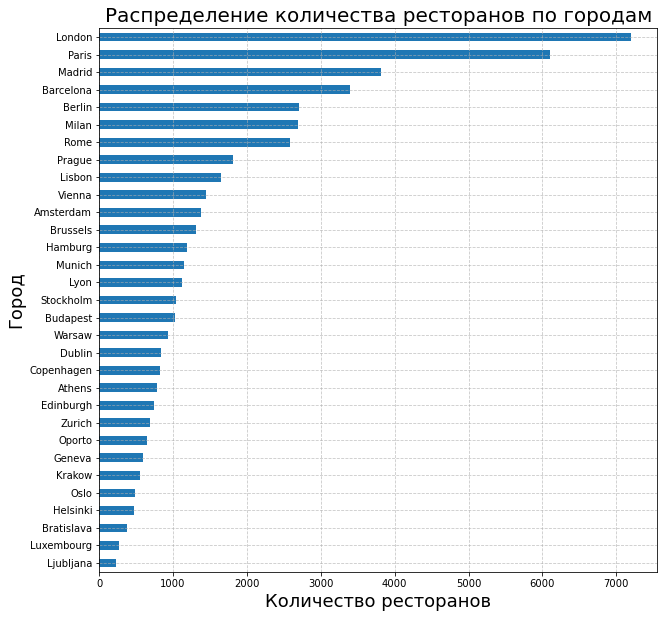

In [1029]:
plt.rcParams['figure.figsize'] = (10, 10)
data['City'].value_counts(ascending=True).plot(kind='barh')
plt.gca().set_xlabel('Количество ресторанов', fontsize=18)
plt.gca().set_ylabel('Город', fontsize=18)
plt.title("Распределение количества ресторанов по городам", fontsize=20)
plt.grid(linestyle='--', alpha=0.7)

Создадим признак страны (возможно это пригодится для обзора кухонь)

In [1030]:
country = {
        'Paris': 'France',
        'Stockholm': 'Sweden',
        'London': 'United Kingdom',
        'Berlin': 'Germany',
        'Munich': 'Germany',
        'Oporto': 'Portugal',
        'Milan': 'Italy',
        'Bratislava': 'Slovakia',
        'Vienna': 'Austria',
        'Rome': 'Italy',
        'Barcelona': 'Spain',
        'Madrid': 'Spain',
        'Dublin': 'Ireland',
        'Brussels': 'Belgium',
        'Zurich': 'Switzerland',
        'Warsaw': 'Poland',
        'Budapest': 'Hungary',
        'Copenhagen': 'Denmark',
        'Amsterdam': 'Netherlands',
        'Lyon': 'France',
        'Hamburg': 'Germany',
        'Lisbon': 'Portugal',
        'Prague': 'Chechia',
        'Oslo': 'Norway',
        'Helsinki': 'Finland',
        'Edinburgh': 'United Kingdom',
        'Geneva': 'Switzerland',
        'Ljubljana': 'Slovenia',
        'Athens': 'Greece',
        'Luxembourg': 'Luxemburg',
        'Krakow': 'Poland'}

In [1031]:
data['Country'] = data.loc[:, ('City')].apply(lambda x: country[x])

Создаем новый признак на основе признака City - Численость населения.

In [1032]:
# Численость населения вгородах
pop = {'London': 8_908_081, 'Paris':2_148_327, 'Madrid': 3_266_126, 'Barcelona': 1_664_182, 'Berlin': 3_644_826,
       'Milan': 1_378_689, 'Rome': 2_870_500, 'Prague': 1_301_132, 'Lisbon': 505_526, 'Vienna': 1_897_491, 
       'Amsterdam': 872_757, 'Brussels': 179_277, 'Hamburg': 1_841_179, 'Munich': 1_471_508, 'Lyon': 506_615,
       'Stockholm': 961_609, 'Budapest': 1_752_286, 'Warsaw': 1_790_658, 'Dublin': 1_173_179, 'Copenhagen': 615_993,
       'Athens': 664_046, 'Edinburgh': 488_100, 'Zurich': 428_737, 'Oporto': 237_591, 'Geneva': 200_548, 'Krakow': 779_115,
       'Oslo': 673_469, 'Helsinki': 655_281, 'Bratislava': 437_725, 'Luxembourg': 626_108, 'Ljubljana': 284_355
      }

In [1033]:
data['Pop'] = data.loc[:, ('City')].apply(lambda x: pop[x])


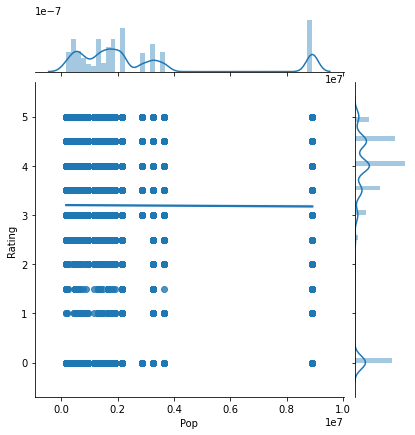

In [1034]:
sns.jointplot(x='Pop', y='Rating', data=data, kind='reg')

Явной зависимости нет. Создадим категориальную, порядковую переменную на основе признака Pop. Ранжирование численности городов на 5 групп. 

1    18477
3    16300
2    15223
Name: Pop_cat, dtype: int64


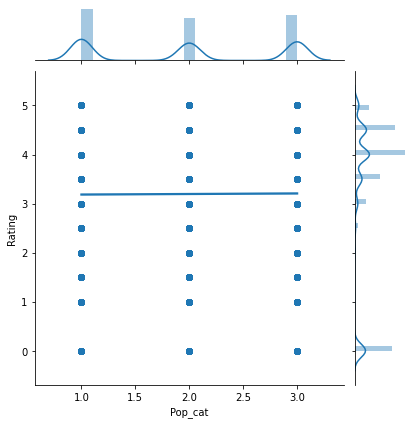

In [1035]:
data['Pop_cat'] = city_pop_cut(data['Pop'], quant=3)
print(data['Pop_cat'].value_counts())
sns.jointplot(x='Pop_cat', y='Rating', data=data, kind='reg')

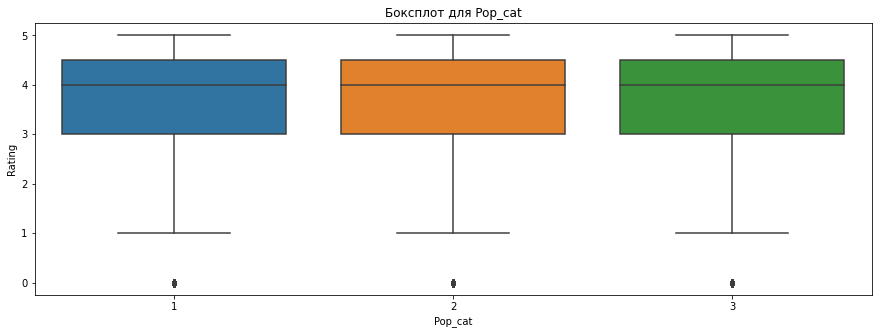

In [1036]:
draw_bp(data, 'Pop_cat')

Создаем новый бинарный признак на основе признака City - Столица. (is_capital)

In [1037]:
capital = {'London': 1, 'Paris':1, 'Madrid':1, 'Barcelona': 0, 'Berlin':1,
       'Milan':0, 'Rome':1, 'Prague':1, 'Lisbon':1, 'Vienna':1, 
       'Amsterdam':1, 'Brussels':1, 'Hamburg':0, 'Munich':0, 'Lyon':0,
       'Stockholm':1, 'Budapest':1, 'Warsaw':1, 'Dublin':1, 'Copenhagen':1,
       'Athens':1, 'Edinburgh':1, 'Zurich':1, 'Oporto':0, 'Geneva':0, 'Krakow':0,
       'Oslo':1, 'Helsinki':1, 'Bratislava':1, 'Luxembourg':1, 'Ljubljana':1
      }

In [1038]:
data['Is_capital'] = data.loc[:, ('City')].apply(lambda x: capital[x])

In [1039]:
data['polis'] = data.loc[:, ('City')] # Оставим для анализа кухонь, потом удалим.

City превратим в dummy-переменную, с помощью One-Hot Encoding

In [1040]:
data = pd.get_dummies(data, columns=[ 'City',], dummy_na=False) # У городов нет пропусков - не будет лишнего столбца

In [1041]:
data.head(5)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,City_Munich,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich
0,id_0,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,...,0,0,0,1,0,0,0,0,0,0
1,id_1,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,id_2,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,id_3,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,id_4,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,...,0,0,0,0,0,0,0,0,0,0


#########################################################################################################################

#### Cousine Style - виды кухни которые предствлены в ресторане

In [1042]:
display(data['Cuisine Style'].describe())
display(data['Cuisine Style'].isna().value_counts())

count           38410
unique          10731
top       ['Italian']
freq             1332
Name: Cuisine Style, dtype: object

False    38410
True     11590
Name: Cuisine Style, dtype: int64

In [1043]:
cuisine_count(data)

Всего в датасете представлено 125 кухонь


Сделаем значения признака Cuisine Style в виде списка

In [1044]:
data['Cuisine Style'] = data['Cuisine Style'].apply(clean_name)

In [1045]:
data['Cuisine Style'].explode().value_counts()

Vegetarian Friendly    14021
European               12561
Unknown                11590
Mediterranean           7820
Italian                 7433
                       ...  
Fujian                     2
Burmese                    1
Latvian                    1
Salvadoran                 1
Xinjiang                   1
Name: Cuisine Style, Length: 126, dtype: int64

Заменим пустые значения на список из 2х самых популярных кухонь  "European" и "Vegetarian Friendly". Более того в датасете седержатся только города Европы и европейская кухня подходит идеально. 

In [1046]:
data['Cuisine Style'] = data['Cuisine Style'].apply(lambda x: ['European', 'Vegetarian Friendly'] 
                                                                    if x == ['Unknown'] else x )

In [1047]:
display(data['Cuisine Style'].isna().sum()) # пропуски заполнены. 

0

До того как переводить типы кухонь в dummy-переменную, попробуем узнать еще, что-нибудь о ресторанах и их кухнях. 

- Сначала посмотрим, в каком городе самое большое разнообразие кухонь.

In [1048]:
# Создадим отдельный датасет из городов и кухонь и разобьем колонку "кухни" по 1 типу на строку.
df_cuisine = data.loc[:, ('polis', 'Cuisine Style')]
df_cuisine = df_cuisine.explode('Cuisine Style')
# Создадим словарь к тором будут храниться название городов и кухни, котрые предствалены в их ресторанах
city_poly_cuisine = {}
# Создадим словарь к тором будут храниться название городов и количество кухонь, котрые предствалены в их ресторанах
city_num_poly_cuisine = {}
for polis in df_cuisine['polis']:
    # Если в словаре нет ключа в виде города добавляем его
    if polis not in city_poly_cuisine:
        city_poly_cuisine[polis] = set(df_cuisine.loc[df_cuisine['polis'] == polis, 'Cuisine Style'].unique())
        city_num_poly_cuisine[polis] = df_cuisine.loc[df_cuisine['polis'] == polis, 'Cuisine Style'].nunique()
    else:
        continue 

Добавим новый признак в датасет - количество уникальных кухонь в ресторанах каждого города. 

In [1049]:
data['poly_cuisine'] = data.loc[:, ('polis')].apply(lambda x: city_num_poly_cuisine[x])

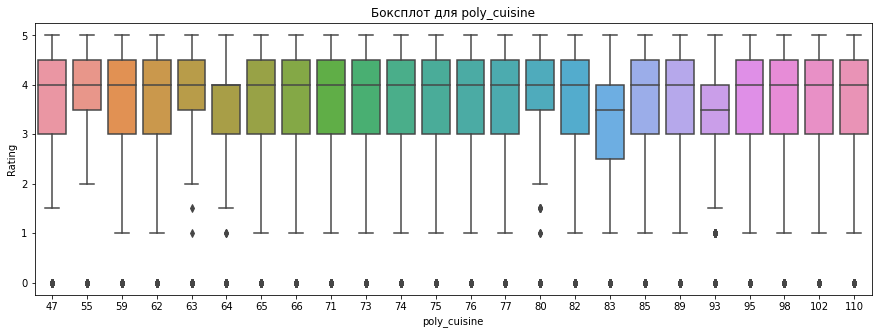

In [1050]:
draw_bp(data, 'poly_cuisine')

In [1051]:
corrt = data.loc[:, ('polis', 'poly_cuisine', 'Rating')]
corrt.corr()

,poly_cuisine,Rating
poly_cuisine,1.000000,-0.014275
Rating,-0.014275,1.000000


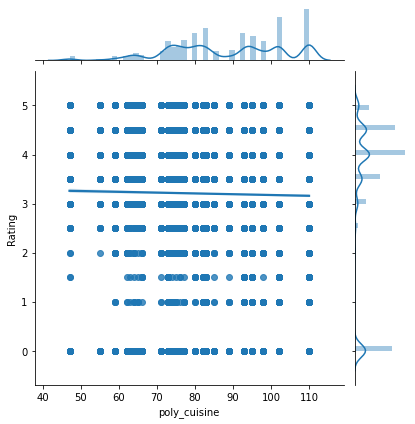

In [1052]:
sns.jointplot(x='poly_cuisine', y='Rating', data=data, kind='reg')

Корееляция этого признака с целевой переменной очень маленькая, обратная. Если после анализа значимости признаков этот он окажется не нужным, удалим его.

- Посмотрим есть ли в ресторане местаня кухня. И создадим категориальный признак 1- есть, 0 - нет.

In [1053]:
local_cuisine = {
            'United Kingdom': ['British','Scottish'],
            'Spain': ['Spanish', 'Mediterranean'],
            'France': ['French','Central European'], 
            'Italy': ['Italian','Central European', 'Mediterranean'],
            'Germany': ['Dutch','German','Central European'],
            'Portugal': ['Portuguese'],
            'Chechia': ['Czech','Eastern European'],
            'Poland':['Polish','Eastern European'],
            'Austria': ['Austrian','Central European'],
            'Netherlands':['Scandinavian'],
            'Belgium': ['Belgian','Eastern European'],
            'Switzerland':['Swiss','Central European'],
            'Sweden':['Swedish', 'Scandinavian'],
            'Hungary':['Hungarian','Eastern European'],
            'Ireland':['Irish'],
            'Denmark':['Scandinavian'],
            'Greece':['Greece', 'Mediterranean'],
            'Norway':['Scandinavian'],
            'Finland':['Scandinavian'],
            'Slovakia':['Eastern European'],
            'Luxemburg':['Eastern European'],
            'Slovenia':['Slovenian','Eastern European']
}

In [1054]:
data['local_cuisine'] = 0 # Сначала создадим колонку, заполненную 0
for i in range(len(data)):
    i_country = data['Country'][i] # Для каждой строки (ресторана) определяем страну
    for cuis in local_cuisine[i_country]: # Для каждого типа кухни из словаря
        if cuis in data['Cuisine Style'][i]:
            data['local_cuisine'].loc[i] = 1
            break
        else:
            pass

C:\Users\Grampus\anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [1055]:
data['local_cuisine'].value_counts()

0    32964
1    17036
Name: local_cuisine, dtype: int64

Большинство ресторанов не имеют местой кухни.

Создаем dummy-переменную по куххян

In [1056]:
data['Cuisine Style']

0                                               [Bar, Pub]
1        [European, Scandinavian, Gluten Free Options, ...
2                                    [Vegetarian Friendly]
3        [Italian, Mediterranean, European, Vegetarian ...
4        [Italian, Mediterranean, European, Seafood, Ve...
                               ...                        
49995    [Italian, Vegetarian Friendly, Vegan Options, ...
49996    [French, American, Bar, European, Vegetarian F...
49997                                    [Japanese, Sushi]
49998    [Polish, European, Eastern European, Central E...
49999                                            [Spanish]
Name: Cuisine Style, Length: 50000, dtype: object

In [1057]:
mlb = MultiLabelBinarizer()
data_cuisine = pd.DataFrame(mlb.fit_transform(data['Cuisine Style']), columns=mlb.classes_)
data = pd.concat([data, data_cuisine], axis=1)
data

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,Ukrainian,Uzbek,Vegan Options,Vegetarian Friendly,Venezuelan,Vietnamese,Welsh,Wine Bar,Xinjiang,Yunnan
0,id_0,"[Bar, Pub]",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,id_1,"[European, Scandinavian, Gluten Free Options, ...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,...,0,0,1,1,0,0,0,0,0,0
2,id_2,[Vegetarian Friendly],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,...,0,0,0,1,0,0,0,0,0,0
3,id_3,"[Italian, Mediterranean, European, Vegetarian ...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,...,0,0,0,1,0,0,0,0,0,0
4,id_4,"[Italian, Mediterranean, European, Seafood, Ve...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,id_499,"[Italian, Vegetarian Friendly, Vegan Options, ...",500.0,$$ - $$$,79.0,"[['The real Italian experience!', 'Wonderful f...",/Restaurant_Review-g187849-d2104414-Reviews-Ro...,d2104414,1,4.5,...,0,0,1,1,0,0,0,0,0,0
49996,id_6340,"[French, American, Bar, European, Vegetarian F...",6341.0,$$ - $$$,542.0,"[['Parisian atmosphere', 'Bit pricey but inter...",/Restaurant_Review-g187147-d1800036-Reviews-La...,d1800036,1,3.5,...,0,0,0,1,0,0,0,0,0,0
49997,id_1649,"[Japanese, Sushi]",1652.0,NaN,4.0,"[['Good by swedish standards', 'A hidden jewel...",/Restaurant_Review-g189852-d947615-Reviews-Sus...,d947615,1,4.5,...,0,0,0,0,0,0,0,0,0,0
49998,id_640,"[Polish, European, Eastern European, Central E...",641.0,$$ - $$$,70.0,"[['Underground restaurant', 'Oldest Restaurant...",/Restaurant_Review-g274856-d1100838-Reviews-Ho...,d1100838,1,4.0,...,0,0,0,1,0,0,0,0,0,0


#########################################################################################################################

### Price Range

In [1058]:
print(data['Price Range'].describe())
print(data['Price Range'].explode().value_counts())
print(data['Price Range'].isna().sum())


count        32639
unique           3
top       $$ - $$$
freq         23041
Name: Price Range, dtype: object
$$ - $$$    23041
$            7816
$$$$         1782
Name: Price Range, dtype: int64
17361


Заполним пропуски самым частым значением - Средним ценовым сигментом.


In [1059]:
data['Price Range'] = data['Price Range'].fillna('$$ - $$$')

Признак Price Range - порядковый категориальный признак. Закодируем его методом replace() как:

- \$ - низкий ценовой сегмент стоимость = 1


- \$\$ - средний ценовой сегмент = 2 


- \$$\$$ - высокий ценовой сегмент = 3

In [1060]:
cleanup_price ={'Price Range': {'$':1, '$$ - $$$':2, '$$$$':3 }}
data.replace(cleanup_price, inplace=True)

In [1061]:
data['Price Range'].describe()

count    50000.000000
mean         1.879320
std          0.421189
min          1.000000
25%          2.000000
50%          2.000000
75%          2.000000
max          3.000000
Name: Price Range, dtype: float64

###  Number of Reviews


In [1062]:
data['Number of Reviews'].isna().value_counts() # есть пропуски

False    46800
True      3200
Name: Number of Reviews, dtype: int64

In [1063]:
data['Number of Reviews'].value_counts(ascending=False)[:20] 

2.0     2403
3.0     2042
4.0     1707
5.0     1471
6.0     1258
7.0     1126
8.0     1026
9.0      966
10.0     854
11.0     807
12.0     742
13.0     691
14.0     639
15.0     593
16.0     581
17.0     560
18.0     533
19.0     512
20.0     485
Name: Number of Reviews, dtype: int64

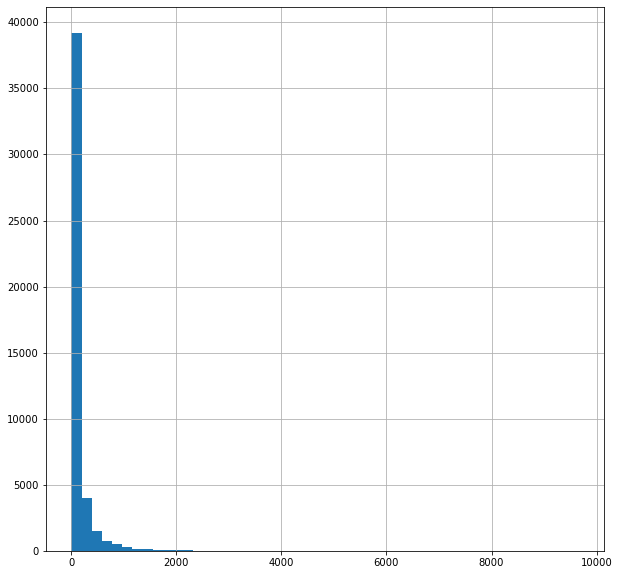

In [1064]:
data['Number of Reviews'].hist(bins=50)

Большинство ресторанов имеют небольшое количество отзывов. Посмотрим как распределены отзывы по городам.

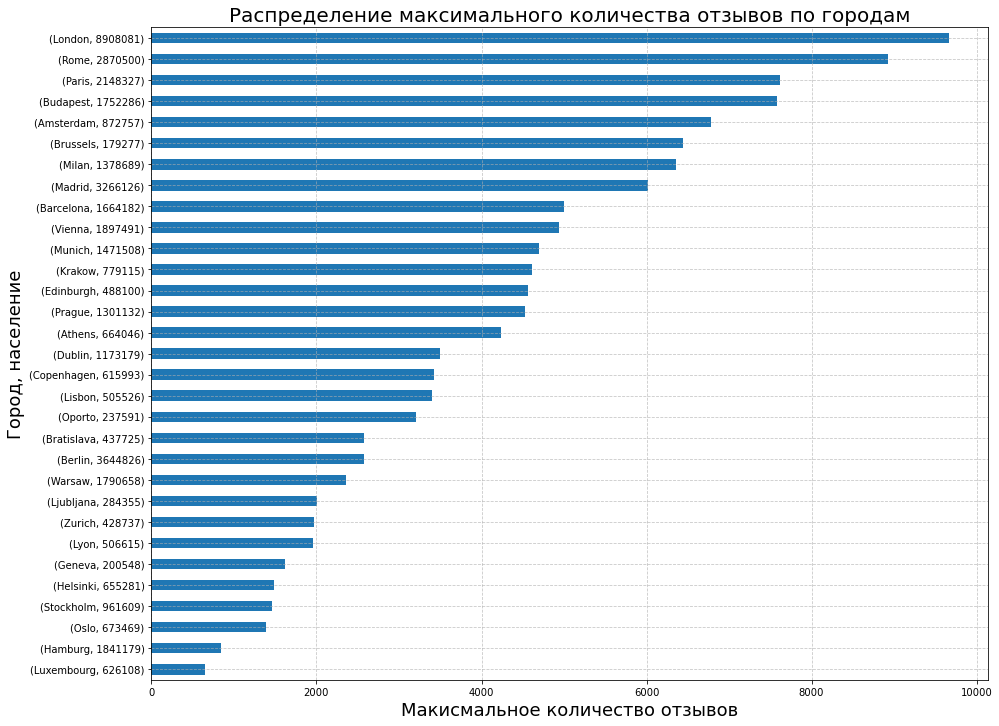

In [1065]:
dd = data.groupby(['polis', 'Pop'])['Number of Reviews'].max().sort_values(ascending=True)
plt.rcParams['figure.figsize'] = (15, 12)
dd.plot(kind='barh')
plt.gca().set_xlabel('Макисмальное количество отзывов', fontsize=18)
plt.gca().set_ylabel('Город, население', fontsize=18)
plt.title("Распределение максимального количества отзывов по городам", fontsize=20)
plt.grid(linestyle='--', alpha=0.7)

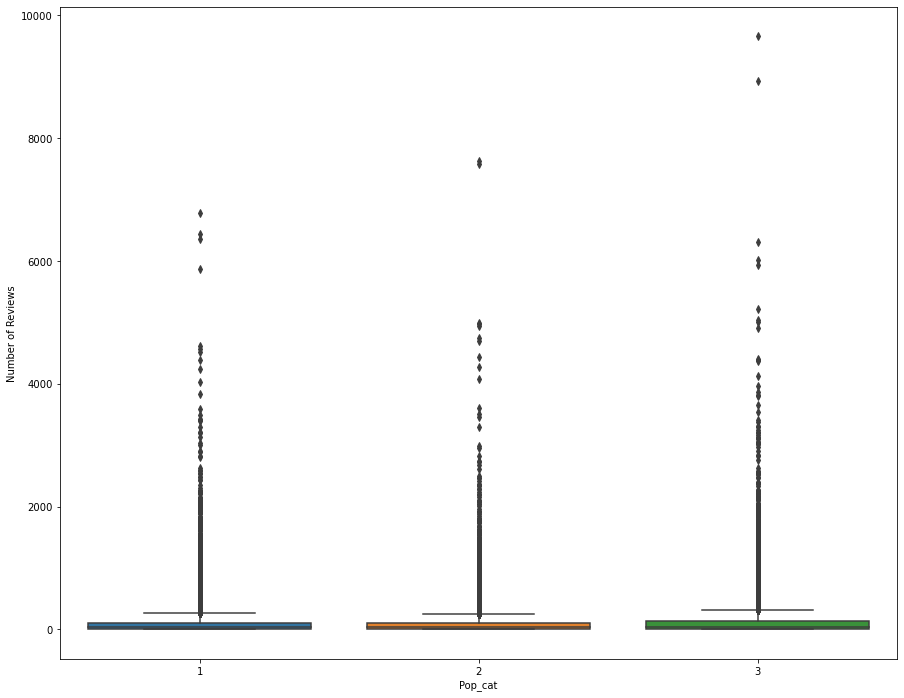

In [1066]:
sns.boxplot(x="Pop_cat", y="Number of Reviews", data=data)

Из графика следует, что количество отзывов зависит от размера населения. В больших городах отзывы оставляют чаще. 

Пустые значения могут точно озачать отсутсвие отзывов. Это было бы точно верно, если бы также отсутсвовали значения и в самих отзывах. Но кроме таких случаев, есть строки где нет количества отзывов, а тексты и даты отзывов присутсвуют и наоборот. Попробуем сделать следующим образом. Те строки, где отсутсвует и количество отзывов и сам отзыв, заменим на 0 - Отзывов нет.

Далее, будем заменять отсуствующие значения средним значением.

In [1067]:
# Количество пропусков на начало замены
data['Number of Reviews'].isna().sum()

3200

In [1068]:
data['Reviews'] = data['Reviews'].astype('str')

In [1069]:
for index in data[data['Number of Reviews'].isna() == True].index:
    if len(data[data['Number of Reviews'].isna() == True].loc[index][5]) <=8:
        data['Number of Reviews'].loc[index] = 0 

C:\Users\Grampus\anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [1070]:
data['Number of Reviews'].isna().sum()

1176

In [1071]:
median = data['Number of Reviews'].median()
data['Number of Reviews'] = data['Number of Reviews'].apply (lambda x: median if pd.isnull(x) else x)

In [1072]:
data['Number of Reviews'].isna().value_counts()

False    50000
Name: Number of Reviews, dtype: int64

Добавим новый признак - среднее количество отзывов в городе. 

In [1073]:
NoF_per_city_mean = data.groupby('polis')['Number of Reviews'].mean()
data['NoF_per_city_mean'] = data['polis'].apply(lambda x: NoF_per_city[x]) 

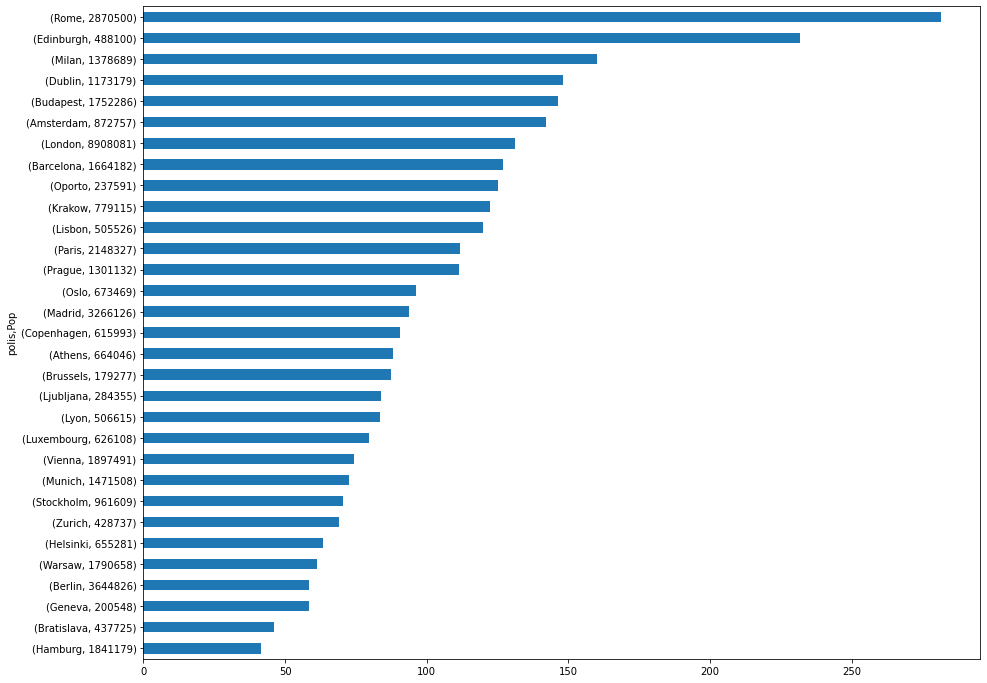

In [1074]:
dd2 = data.groupby(['polis', 'Pop'])['Number of Reviews'].mean().sort_values(ascending=True)
plt.rcParams['figure.figsize'] = (15, 12)
dd2.plot(kind='barh')

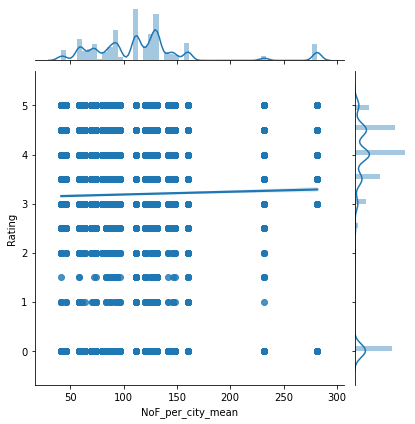

In [1075]:
sns.jointplot(x='NoF_per_city_mean', y='Rating', data=data, kind='reg')

#### Reviews

Kоличество пустых значений. Стоит отметить, что здесь пустые значения это не Nan, а пустые строка длиной не более 8 знаков (пустые скобки).

In [1076]:
summ = 0
for rev in data['Reviews']:
    if len(rev)<=8:
        summ+=1
print(summ)

8114


In [1077]:
review_dt_extract(data)

In [1078]:
print("Самая свежая дата", data[['review_date_1', 'review_date_2']].max().max())
print("Самая раняя дата", data[['review_date_1', 'review_date_2']].min().min())

max_days = abs(data['review_date_1'] - data['review_date_2']).max()
print("Количество дней", max_days)

Самая свежая дата 2018-02-26 00:00:00
Самая раняя дата 2004-04-21 00:00:00
Количество дней 3296 days 00:00:00


Создадим признак review_day_freq. Как часто оставляют отзывы в ресторане. Пустые значения заполним 0.

In [1079]:
data['review_day_freq'] = abs((data['review_date_1'] - data['review_date_2']).dt.days)
data['review_day_freq'] = data['review_day_freq'].fillna(0)

#### URL_TA и ID_TA

In [1080]:
data['URL_TA'].describe() # предствляет собой страницы ресторанов с трипэдвайзера - в модели учавствовать не будет (хотя интересно что есть повторяющееся значения)

count                                                 50000
unique                                                49963
top       /Restaurant_Review-g187514-d13002276-Reviews-D...
freq                                                      2
Name: URL_TA, dtype: object

In [1081]:
data['ID_TA'].describe() # предствляет собой ID ресторана на том же самом сайте - в модели учавствовать не будет 

count       50000
unique      49963
top       d793170
freq            2
Name: ID_TA, dtype: object

### Ranking 

Посмотрим распределение признака

In [1082]:
#display(data.Ranking.describe()) # пропусков нет - но сами значения достаточно большие - можно сделать STD нормализацию
#display(data['Number of Reviews'].describe) # пропуски уже заполнил - можно сделать сделать STD нормализацию

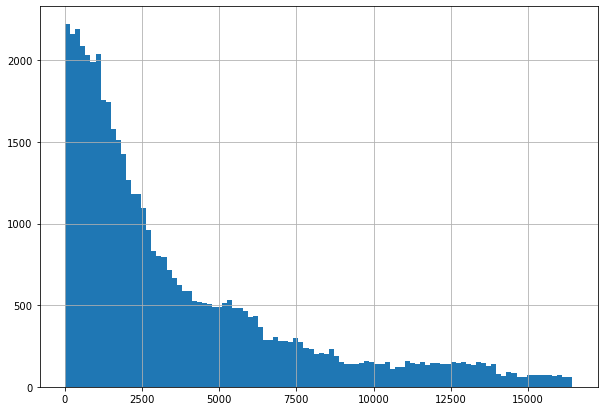

In [1083]:
plt.rcParams['figure.figsize'] = (10,7)
data['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

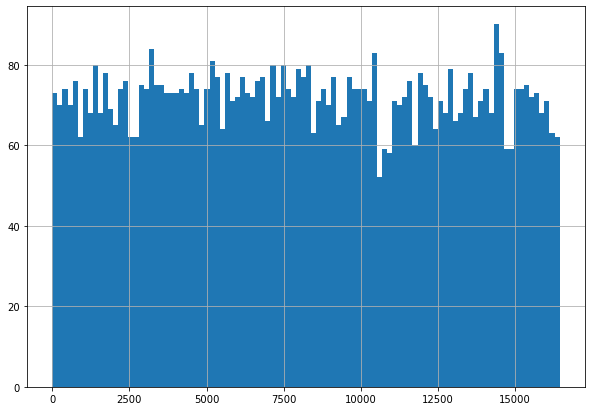

In [1084]:
data['Ranking'][data['polis'] =='London'].hist(bins=100)

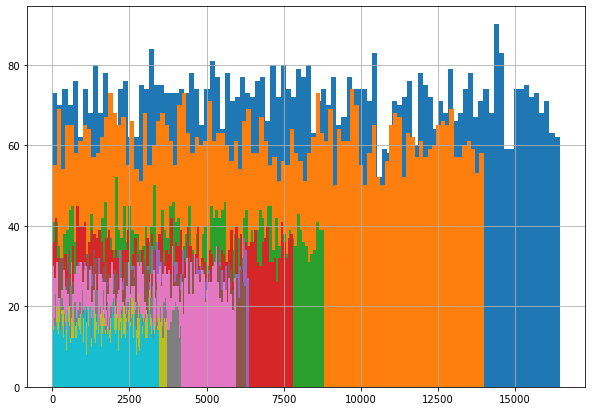

In [1085]:
# посмотрим на топ 10 городов
for x in (data['polis'].value_counts())[0:10].index:
    data['Ranking'][data['polis'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

>Подумайте как из этого можно сделать признак для вашей модели. Я покажу вам пример, как визуализация помогает находить взаимосвязи. А далее действуйте без подсказок =) 


Признак Ranking зависит от количества ресторанов в городе, а следовательно, от размера города, который в нашем случае определяется по количеству населения. 

Согласно карте корреляций признак Ranking имеет обратную корреляцию с целевой переменной Rating. Значит, чем больше номер позиции ресторана в городе, тем меньше рейтинг. 

Предположим, что номер позиции Ranking прикрепляется к ресторану не навсегда, а меняется в зависимости от каких-то других факторов. Тогда ресторан может двигаться в некотором диапазоне Ranking в своем городе. 
Попробуем перевести признак Ranking в порядковую категориальную переменную разбив ее на 5 интервалов («Топовый», «высокий», «средний», «ниже среднего», «низкий»), где:
- 5 - Топовый
- ...
- 1 - Низкий
- 0 - Нет ранга

- При этом 5<4<3<2<1 

Однако, стоит учесть, что в маленьких городах ресторанов в принципе меньше, чем в больших. А значит, например интервал «высокого» ранга в маленьком городе будет отличаться от аналогичного ранга в больших городах. 

Поэтому данный признак должен быть собственный для каждой группы городов. В нашем случае таких групп – 3. 


In [1086]:
rank_for_city(data)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,Xinjiang,Yunnan,NoF_per_city_mean,review_date,review_date_1,review_date_2,review_day_freq,Big_City_Rank,Mid_City_Rank,Lit_City_Rank
0,id_0,"[Bar, Pub]",12963.0,2,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,...,0,0,111.787656,[],NaT,NaT,0.0,0.0,5.0,0.0
1,id_1,"[European, Scandinavian, Gluten Free Options, ...",106.0,2,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,...,0,0,63.471579,"[12/05/2017, 10/29/2017]",2017-12-05,2017-10-29,37.0,0.0,0.0,1.0
2,id_2,[Vegetarian Friendly],810.0,2,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,...,0,0,231.711409,"[12/28/2017, 12/06/2017]",2017-12-28,2017-12-06,22.0,0.0,0.0,2.0
3,id_3,"[Italian, Mediterranean, European, Vegetarian ...",1669.0,3,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,...,0,0,131.324343,"[12/06/2017, 11/22/2017]",2017-12-06,2017-11-22,14.0,1.0,0.0,0.0
4,id_4,"[Italian, Mediterranean, European, Seafood, Ve...",37.0,3,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,...,0,0,46.086842,"[02/08/2018, 01/24/2018]",2018-02-08,2018-01-24,15.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,id_499,"[Italian, Vegetarian Friendly, Vegan Options, ...",500.0,2,79.0,"[['The real Italian experience!', 'Wonderful f...",/Restaurant_Review-g187849-d2104414-Reviews-Ro...,d2104414,1,4.5,...,0,0,160.211952,"[12/16/2017, 11/12/2017]",2017-12-16,2017-11-12,34.0,0.0,0.0,2.0
49996,id_6340,"[French, American, Bar, European, Vegetarian F...",6341.0,2,542.0,"[['Parisian atmosphere', 'Bit pricey but inter...",/Restaurant_Review-g187147-d1800036-Reviews-La...,d1800036,1,3.5,...,0,0,111.787656,"[12/21/2017, 12/12/2017]",2017-12-21,2017-12-12,9.0,0.0,4.0,0.0
49997,id_1649,"[Japanese, Sushi]",1652.0,2,4.0,"[['Good by swedish standards', 'A hidden jewel...",/Restaurant_Review-g189852-d947615-Reviews-Sus...,d947615,1,4.5,...,0,0,70.367861,"[11/03/2016, 04/12/2008]",2016-11-03,2008-04-12,3127.0,0.0,0.0,4.0
49998,id_640,"[Polish, European, Eastern European, Central E...",641.0,2,70.0,"[['Underground restaurant', 'Oldest Restaurant...",/Restaurant_Review-g274856-d1100838-Reviews-Ho...,d1100838,1,4.0,...,0,0,61.181622,"[07/11/2017, 06/18/2017]",2017-07-11,2017-06-18,23.0,0.0,1.0,0.0


### Посмотрим распределение целевой переменной

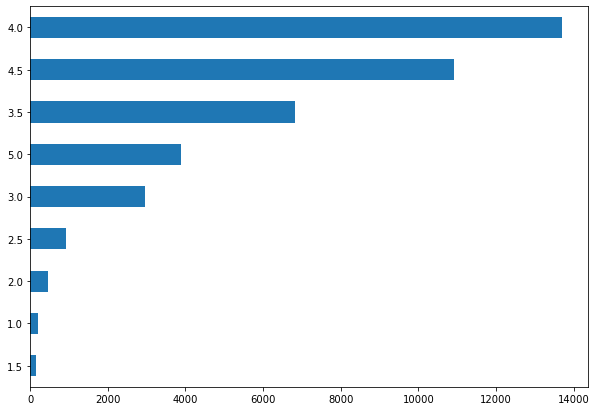

In [1087]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000019EEA78C430>,
      dtype=object)

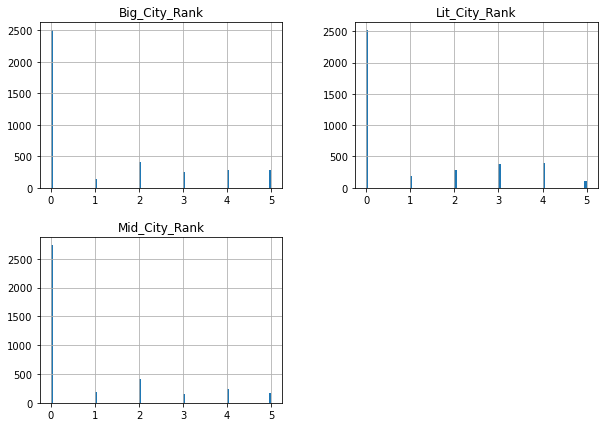

In [1088]:
data[['Big_City_Rank', 'Mid_City_Rank', 'Lit_City_Rank']][data['Rating'] == 5].hist(bins=100)

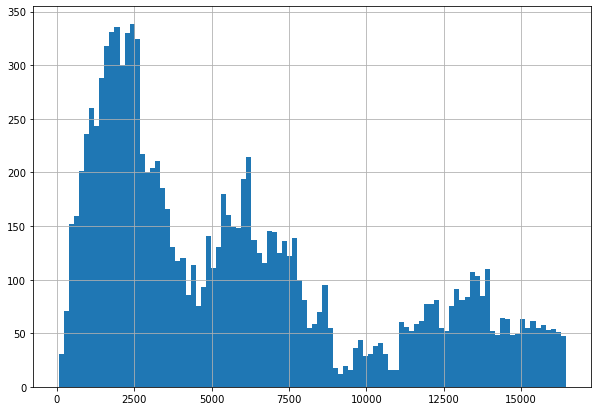

In [1089]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

### И один из моих любимых - [корреляция признаков](https://ru.wikipedia.org/wiki/Корреляция)
На этом графике уже сейчас вы сможете заметить, как признаки связаны между собой и с целевой переменной.

,Ranking,Price Range,Number of Reviews,Rating,Restaurant_chain,Pop,Is_capital,City_Amsterdam,City_Athens,City_Barcelona,...,Vietnamese,Welsh,Wine Bar,Xinjiang,Yunnan,NoF_per_city_mean,review_day_freq,Big_City_Rank,Mid_City_Rank,Lit_City_Rank
Ranking,1.000000,-0.026334,-0.221929,-0.109897,-0.502592,0.567760,0.181705,-0.094100,-0.094479,0.015683,...,-0.009851,-0.005372,-0.041328,0.003277,-0.004805,0.103818,0.069228,0.622084,0.327864,-0.289449
Price Range,-0.026334,1.000000,0.108218,-0.012176,0.005652,-0.017115,-0.001083,-0.003031,-0.023953,-0.014778,...,-0.077088,0.014480,0.022006,0.001281,0.001812,-0.086122,-0.035108,-0.035361,0.019523,-0.026815
Number of Reviews,-0.221929,0.108218,1.000000,0.011158,0.061363,0.024141,0.009373,0.014591,-0.012817,0.009210,...,-0.015625,0.002397,0.008127,-0.001192,0.001113,0.177588,-0.088623,-0.086520,-0.098071,-0.107308
Rating,-0.109897,-0.012176,0.011158,1.000000,0.150831,-0.004963,0.010428,0.007447,0.016852,-0.000703,...,0.013444,-0.000883,0.017776,0.002112,-0.004430,0.016814,-0.025971,-0.028778,-0.030873,-0.043089
Restaurant_chain,-0.502592,0.005652,0.061363,0.150831,1.000000,-0.286427,-0.109300,0.030219,0.022624,0.052005,...,0.005007,0.002224,0.022848,0.001284,0.001816,-0.029264,-0.040213,-0.286538,-0.096198,0.130055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NoF_per_city_mean,0.103818,-0.086122,0.177588,0.016814,-0.029264,0.135937,0.052777,0.082163,-0.072175,0.051860,...,-0.047913,-0.000272,0.025683,-0.000476,-0.001486,1.000000,-0.038934,0.163056,-0.112393,0.022173
review_day_freq,0.069228,-0.035108,-0.088623,-0.025971,-0.040213,-0.017935,-0.003167,-0.022961,-0.000294,-0.005523,...,0.007664,-0.003756,-0.012375,0.002144,-0.000893,-0.038934,1.000000,0.007774,0.051485,0.017586
Big_City_Rank,0.622084,-0.035361,-0.086520,-0.028778,-0.286538,0.817430,0.326481,-0.101301,-0.075722,-0.162774,...,-0.014494,-0.001487,-0.024111,-0.002697,-0.003814,0.163056,0.007774,1.000000,-0.347340,-0.397016
Mid_City_Rank,0.327864,0.019523,-0.098071,-0.030873,-0.096198,-0.169973,-0.144275,-0.096740,-0.072313,0.381920,...,0.025934,-0.004461,-0.001343,0.008705,0.000346,-0.112393,0.051485,-0.347340,1.000000,-0.379141


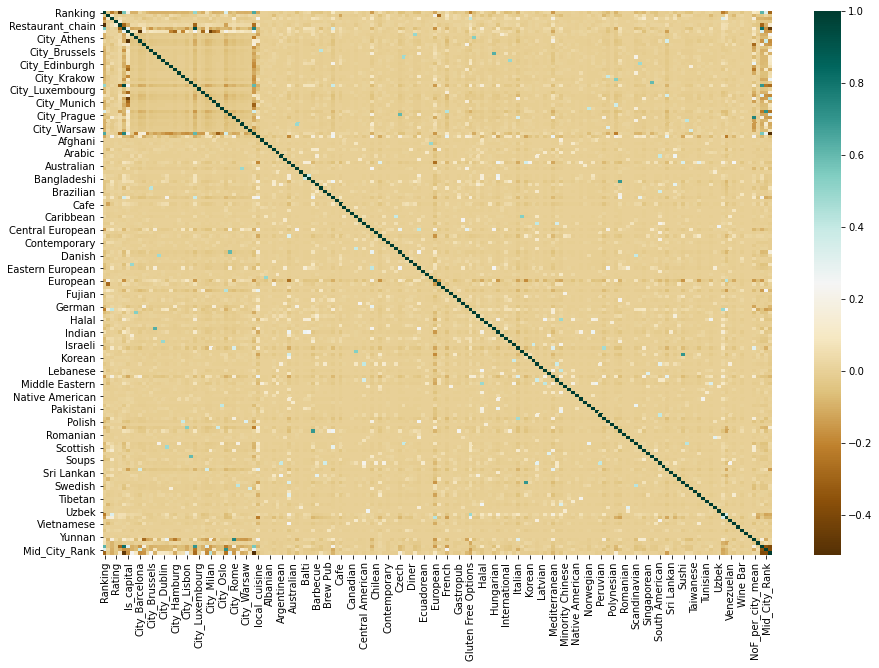

In [1090]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),cmap="BrBG")
data.drop(['sample'], axis=1).corr()

Вообще благодаря визуализации в этом датасете можно узнать много интересных фактов, например:
* где больше Пицерий в Мадриде или Лондоне?
* в каком городе кухня ресторанов более разнообразна?

придумайте свои вопрос и найдите на него ответ в данных)

# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [1091]:
# на всякий случай, заново подгружаем данные
#df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
#df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
#df_train['sample'] = 1 # помечаем где у нас трейн
#df_test['sample'] = 0 # помечаем где у нас тест
#df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

#data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
#data.info()

In [1092]:
#def preproc_data(df_input):
#'''includes several functions to pre-process the predictor data.'''
    
    #df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    #df_output.drop(['Restaurant_id','ID_TA',], axis = 1, inplace=True)
    
    
    # ################### 2. NAN ############################################################## 
    # Далее заполняем пропуски, вы можете попробовать заполнением средним или средним по городу и тд...
    #df_output['Number of Reviews'].fillna(0, inplace=True)
    # тут ваш код по обработке NAN
    # ....
    
    
    # ################### 3. Encoding ############################################################## 
    # для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
    #df_output = pd.get_dummies(df_output, columns=[ 'City',], dummy_na=True)
    # тут ваш код не Encoding фитчей
    # ....
    
    
    # ################### 4. Feature Engineering ####################################################
    # тут ваш код не генерацию новых фитчей
    # ....
    
    
    # ################### 5. Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
    #object_columns = [s for s in df_output.columns if df_output[s].dtypes == 'object']
    #df_output.drop(object_columns, axis = 1, inplace=True)
    
    #return df_output

>По хорошему, можно было бы перевести эту большую функцию в класс и разбить на подфункции (согласно ООП). 

## Проверка DATA

In [1093]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 182 entries, Restaurant_id to Lit_City_Rank
dtypes: category(1), datetime64[ns](2), float64(9), int32(125), int64(6), object(8), uint8(31)
memory usage: 34.9+ MB


#### Запускаем и проверяем что получилось

In [1005]:
#df_preproc = preproc_data(data)
#df_preproc.sample(10)

In [1006]:
#df_preproc.info()

In [1095]:
data.drop(['Restaurant_id','ID_TA',], axis = 1, inplace=True)
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis=1, inplace=True)

In [1096]:
data.drop(['review_date_1', 'review_date_2'],axis=1, inplace=True)

In [1097]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 172 entries, Ranking to Lit_City_Rank
dtypes: category(1), float64(9), int32(125), int64(6), uint8(31)
memory usage: 31.1 MB


In [1098]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

In [1099]:
train_data

,Ranking,Price Range,Number of Reviews,Rating,Restaurant_chain,Pop,Pop_cat,Is_capital,City_Amsterdam,City_Athens,...,Vietnamese,Welsh,Wine Bar,Xinjiang,Yunnan,NoF_per_city_mean,review_day_freq,Big_City_Rank,Mid_City_Rank,Lit_City_Rank
10000,5570.0,2,194.0,3.5,1.0,2148327,2,1,0,0,...,0,0,0,0,0,111.787656,41.0,0.0,4.0,0.0
10001,1537.0,2,10.0,4.0,1.0,961609,1,1,0,0,...,0,0,0,0,0,70.367861,382.0,0.0,0.0,4.0
10002,353.0,3,688.0,4.5,1.0,8908081,3,1,0,0,...,0,0,0,0,0,131.324343,2.0,1.0,0.0,0.0
10003,3458.0,2,3.0,5.0,1.0,3644826,3,1,0,0,...,0,0,0,0,0,58.478743,0.0,2.0,0.0,0.0
10004,621.0,2,84.0,4.0,1.0,1471508,2,0,0,0,...,0,0,0,0,0,72.484716,272.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,500.0,2,79.0,4.5,1.0,1378689,1,0,0,0,...,0,0,0,0,0,160.211952,34.0,0.0,0.0,2.0
49996,6341.0,2,542.0,3.5,1.0,2148327,2,1,0,0,...,0,0,0,0,0,111.787656,9.0,0.0,4.0,0.0
49997,1652.0,2,4.0,4.5,1.0,961609,1,1,0,0,...,0,0,0,0,0,70.367861,3127.0,0.0,0.0,4.0
49998,641.0,2,70.0,4.0,1.0,1790658,2,1,0,0,...,0,0,0,0,0,61.181622,23.0,0.0,1.0,0.0


**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [1100]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [1101]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 171), (40000, 171), (40000, 170), (32000, 170), (8000, 170))

# Model 
Сам ML

In [1102]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [1103]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [1104]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [1105]:
def round_rating_pred(rating_pred):
    if rating_pred <= 0.25:
        return 0.0
    if rating_pred <= 0.75:
        return 0.5
    if rating_pred <= 1.25:
        return 1.0
    if rating_pred <= 1.75:
        return 1.5
    if rating_pred <= 2.25:
        return 2.0
    if rating_pred <= 2.75:
        return 2.5
    if rating_pred <= 3.25:
        return 3.0
    if rating_pred <= 3.75:
        return 3.5
    if rating_pred <= 4.25:
        return 4.0
    if rating_pred <= 4.75:
        return 4.5
    return 5.0


# Round it
for i in range(len(y_pred)):
    y_pred[i] = round_rating_pred(y_pred[i])

In [1106]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.179625


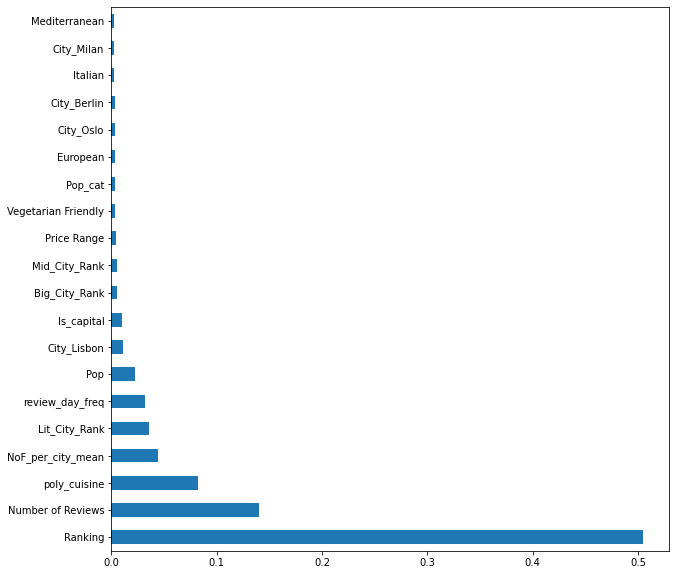

In [1107]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [1424]:
test_data.sample(10)

,Ranking,Number of Reviews,Rating,Restaurant_chain,Pop,Pop_cat,Is_capital,City_Amsterdam,City_Athens,City_Barcelona,...,Burmese,Japanese,Israeli,South American,American,Afghani,Middle Eastern,Hawaiian,Kosher,Turkish
5251,2979.0,7.0,0.0,1.0,872757,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
9822,11364.0,60.0,0.0,1.0,2148327,2,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5965,772.0,59.0,0.0,1.0,2870500,3,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6065,609.0,19.0,0.0,0.0,779115,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2951,810.0,20.0,0.0,1.0,655281,1,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
299,3608.0,29.0,0.0,1.0,3644826,3,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2351,6620.0,9.0,0.0,1.0,3266126,3,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4189,2022.0,316.0,0.0,1.0,8908081,3,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7084,1332.0,198.0,0.0,1.0,1378689,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9520,3176.0,22.0,0.0,1.0,3644826,3,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [63]:
test_data = test_data.drop(['Rating'], axis=1)

In [64]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [65]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [66]:
predict_submission

array([3.005, 4.255, 4.405, ..., 3.015, 4.5  , 4.305])

In [67]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission_1.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.005
1,id_1,4.255
2,id_2,4.405
3,id_3,4.320
4,id_4,4.475
5,id_5,4.645
6,id_6,1.920
7,id_7,2.430
8,id_8,4.115
9,id_9,4.645


# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!
